<a href="https://colab.research.google.com/github/sayakpaul/A-B-testing-with-Machine-Learning/blob/master/EDA_and_data_splitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install facets-overview==1.0.0
!pip install -q pandas==0.25.0

In [2]:
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
from google.colab import widgets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import base64
import re

Using TensorFlow backend.


In [0]:
pd.set_option('display.max_colwidth', 400)
np.random.seed(666)

In [7]:
arxiv_data = pd.read_csv('data/arXivdata.csv')
arxiv_data.head()

,title,labels
0,Dual Recurrent Attention Units for Visual Question Answering,"[""'cs.AI'"", ""'cs.CL'"", ""'cs.CV'"", ""'cs.NE'"", ""'stat.ML'""]"
1,Sequential Short-Text Classification with Recurrent and Convolutional\n Neural Networks,"[""'cs.CL'"", ""'cs.AI'"", ""'cs.LG'"", ""'cs.NE'"", ""'stat.ML'""]"
2,Multiresolution Recurrent Neural Networks: An Application to Dialogue\n Response Generation,"[""'cs.CL'"", ""'cs.AI'"", ""'cs.LG'"", ""'cs.NE'"", ""'stat.ML'""]"
3,Learning what to share between loosely related tasks,"[""'stat.ML'"", ""'cs.AI'"", ""'cs.CL'"", ""'cs.LG'"", ""'cs.NE'""]"
4,A Deep Reinforcement Learning Chatbot,"[""'cs.CL'"", ""'cs.AI'"", ""'cs.LG'"", ""'cs.NE'"", ""'stat.ML'""]"


In [8]:
arxiv_data.shape

(41000, 2)

In [9]:
arxiv_data['labels'] = arxiv_data['labels'].str.replace(r"[\"]", '')
arxiv_data.head()

,title,labels
0,Dual Recurrent Attention Units for Visual Question Answering,"['cs.AI', 'cs.CL', 'cs.CV', 'cs.NE', 'stat.ML']"
1,Sequential Short-Text Classification with Recurrent and Convolutional\n Neural Networks,"['cs.CL', 'cs.AI', 'cs.LG', 'cs.NE', 'stat.ML']"
2,Multiresolution Recurrent Neural Networks: An Application to Dialogue\n Response Generation,"['cs.CL', 'cs.AI', 'cs.LG', 'cs.NE', 'stat.ML']"
3,Learning what to share between loosely related tasks,"['stat.ML', 'cs.AI', 'cs.CL', 'cs.LG', 'cs.NE']"
4,A Deep Reinforcement Learning Chatbot,"['cs.CL', 'cs.AI', 'cs.LG', 'cs.NE', 'stat.ML']"


In [10]:
len(arxiv_data['labels'].unique())

2606

In [11]:
grouped_labels = arxiv_data.groupby('labels').size().reset_index(name='count')
top_100_labels = grouped_labels.nlargest(100, columns="count")
top_100_labels[:10]

,labels,count
759,['cs.CV'],8895
242,['cs.AI'],3788
496,['cs.CL'],3773
1539,"['cs.LG', 'stat.ML']",1655
2603,['stat.ML'],1606
1540,['cs.LG'],1587
2587,"['stat.ML', 'cs.LG']",1305
1796,['cs.NE'],1205
696,"['cs.CV', 'cs.LG']",521
1235,"['cs.LG', 'cs.AI', 'stat.ML']",377


In [12]:
arxiv_data_pruned = arxiv_data[arxiv_data['labels'].isin(top_100_labels['labels'].tolist())]
arxiv_data_pruned.head()

,title,labels
519,Transition-Based Dependency Parsing with Stack Long Short-Term Memory,"['cs.CL', 'cs.LG', 'cs.NE']"
520,A Semisupervised Approach for Language Identification based on Ladder\n Networks,"['cs.CL', 'cs.LG', 'cs.NE']"
521,First-Pass Large Vocabulary Continuous Speech Recognition using\n Bi-Directional Recurrent DNNs,"['cs.CL', 'cs.LG', 'cs.NE']"
523,Syntax-based Deep Matching of Short Texts,"['cs.CL', 'cs.LG', 'cs.NE']"
525,Diverse Embedding Neural Network Language Models,"['cs.CL', 'cs.LG', 'cs.NE']"


In [13]:
arxiv_data_pruned[arxiv_data_pruned['labels']=="['cs.CV']"].head()

,title,labels
23082,A Linear Shift Invariant Multiscale Transform,['cs.CV']
23083,General Theory of Image Normalization,['cs.CV']
23084,A Differential Invariant for Zooming,['cs.CV']
23085,A Parallel Algorithm for Dilated Contour Extraction from Bilevel Images,['cs.CV']
23086,"Image Compression with Iterated Function Systems, Finite Automata and\n Zerotrees: Grand Unification",['cs.CV']


In [14]:
#@title Visualize the Data in Facets
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': arxiv_data_pruned, 'name': 'Data'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

(0, 300)

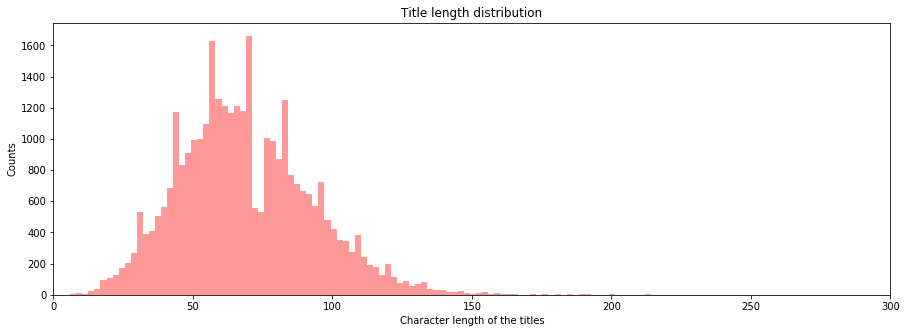

In [15]:
text_lens = arxiv_data_pruned['title'].apply(len).values
fig = plt.figure()
fig.set_size_inches(15, 5)
g = sns.distplot(text_lens, kde=False, bins=100, color='red')
g.set_xlabel('Character length of the titles')
g.set_ylabel('Counts')
g.set_xticks(np.arange(-50, 1200, 50))
g.set_title('Title length distribution')
g.set_xlim(0, 300)

In [16]:
arxiv_data_pruned[arxiv_data_pruned['labels'].str.len()== \
                  arxiv_data_pruned['labels'].str.len().max()]['labels'].unique()

array(["['math.ST', 'cs.LG', 'stat.ML', 'stat.TH']",
       "['stat.ML', 'cs.LG', 'math.ST', 'stat.TH']"], dtype=object)

In [17]:
arxiv_data_pruned[arxiv_data_pruned['labels']=="['math.ST', 'cs.LG', 'stat.ML', 'stat.TH']"].describe()

,title,labels
count,44,44
unique,41,1
top,Discussion: Latent variable graphical model selection via convex\n optimization,"['math.ST', 'cs.LG', 'stat.ML', 'stat.TH']"
freq,4,44


In [18]:
arxiv_data_pruned[arxiv_data_pruned['labels']=="['stat.ML', 'cs.LG', 'math.ST', 'stat.TH']"].describe()

,title,labels
count,59,59
unique,59,1
top,Sequential Low-Rank Change Detection,"['stat.ML', 'cs.LG', 'math.ST', 'stat.TH']"
freq,1,59


In [19]:
arxiv_data_pruned['title_length'] = arxiv_data_pruned['title'].map(len)
arxiv_data_pruned['labels_length'] = arxiv_data_pruned['labels'].map(len)
arxiv_data_pruned.sample(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,title,labels,title_length,labels_length
36285,Price Updating in Combinatorial Prediction Markets with Bayesian\n Networks,"['cs.GT', 'cs.AI']",75,18
15850,Memory-enhanced Decoder for Neural Machine Translation,['cs.CL'],54,9
6488,Rank-to-engage: New Listwise Approaches to Maximize Engagement,"['stat.ML', 'cs.LG']",62,20
23373,Redundant Wavelets on Graphs and High Dimensional Data Clouds,['cs.CV'],61,9
25707,A Directional Diffusion Algorithm for Inpainting,['cs.CV'],48,9
22386,Proceedings of the 5th Workshop on Machine Learning and Interpretation\n in Neuroimaging (MLINI) at NIPS 2015,['stat.ML'],109,11
19592,Hierarchical Multiclass Decompositions with Application to Authorship\n Determination,['cs.AI'],85,9
39949,Real-Time Visual Localisation in a Tagged Environment,"['cs.CV', 'cs.RO']",53,18
36174,Evolving knowledge through negotiation,"['cs.AI', 'cs.HC']",38,18
25076,LOAD: Local Orientation Adaptive Descriptor for Texture and Material\n Classification,['cs.CV'],85,9


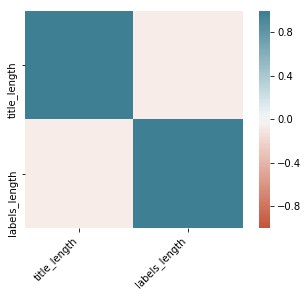

In [20]:
corr = arxiv_data_pruned.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [21]:
X_train, X_test, y_train, y_test = train_test_split(arxiv_data_pruned['title'], 
                                                    arxiv_data_pruned['labels'],
                                                    stratify=np.array(arxiv_data_pruned['labels']),
                                                    test_size=0.2, random_state=666)
X_train.shape, X_test.shape

((26154,), (6539,))

In [0]:
# Incoporate MultiLabelBinarizer

In [28]:
mlb = MultiLabelBinarizer()
mlb.fit(y_train)
mlb.classes_

array([' ', "'", ',', '.', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'L',
       'M', 'N', 'O', 'P', 'R', 'S', 'T', 'V', 'Y', '[', ']', 'a', 'c',
       'h', 'm', 's', 't'], dtype=object)

In [26]:
mlb = MultiLabelBinarizer()
sample_labels = [
    ['stat.ML', 'cs.LG'],
    ['cs.CV', 'cs.RO']
]
mlb.fit(sample_labels)
mlb.classes_

array(['cs.CV', 'cs.LG', 'cs.RO', 'stat.ML'], dtype=object)

In [0]:
np.save('data/X_train.npy', np.array(X_train))
np.save('data/X_test.npy', np.array(X_test))
np.save('data/y_train.npy', np.array(y_train))
np.save('data/y_test.npy', np.array(y_test))

To be added:
- Annotation
- Clean the outputs
- Comments